# CSGO Match Prediction With SVMs

In [230]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Load and restructure data

In [231]:
df = pd.read_csv('./economy.csv', low_memory=False) # load csv
colnames = list(df.columns) # original colnames

In CSGO, a match is finished when either team wins 15 rounds. This means that a match can anywhere between 15 to 30 rounds. We remove unplayed rounds in this step

In [232]:
# Returns an array where each element represents the
# last non null column in that row
winners = df.T.apply(pd.Series.last_valid_index)

The target feature—the team that won the match—is appended to the dataset by going through each row and recording which team won the last round that was played. Since no extra rounds are played after the 15 round quota is reached, a team that wins the last round that is played is also the team that wins the entire match.

In [233]:
winners_col = [] 
winnerarr = np.array(winners) 

# loop through all records of data
for i in range(df.shape[0]): 
    # append whether team 1 won or team 2 won (winnerarr[i][i] returns 1 or 2)
    winners_col.append(df[winnerarr[i]][i]) 

# append new column to data
df['match_winner'] = winners_col 

In [234]:
# We dont need these columns anymore
round_win_col_names = [
 '16_winner',
 '17_winner',
 '18_winner',
 '19_winner',
 '20_winner',
 '21_winner',
 '22_winner',
 '23_winner',
 '24_winner',
 '25_winner',
 '26_winner',
 '27_winner',
 '28_winner',
 '29_winner',
 '30_winner']

# drop round winner columns
df = df.drop(columns=round_win_col_names) 

# drop unecessary columns
df = df.drop(columns=["best_of", "date", "t2_start"])
df = df.drop(columns=["match_id", "event_id"])

# drops rounds past halftime
droprounds = ['16_t1', '17_t1', '18_t1', '19_t1', '20_t1', '21_t1', '22_t1', '23_t1', '24_t1', '25_t1', '26_t1', '27_t1', '28_t1', '29_t1', '30_t1', '16_t2', '17_t2', '18_t2', '19_t2', '20_t2', '21_t2', '22_t2', '23_t2', '24_t2', '25_t2', '26_t2', '27_t2', '28_t2', '29_t2', '30_t2']
df = df.drop(columns=droprounds)

Next, the non-numerical features are encoded into more useful forms. The team names (`team_1` and `team_2`) and map names (`_map`) are converted from strings into unique integer values. Team starting side data is encoded as a single feature (`t1_t`) which is a boolean value set to 1 if `team_1` in the row is starting on the terrorist side.

In [235]:
colnames = list(df.columns) # colnames is column names of new df
xnames = colnames[:len(colnames) - 1] # all features except for last column

# these are the features we will train on
X = df[xnames]

set_of_teams = set(list(X['team_1']) + list(X['team_2'])) # creates a unique list of teams found in dataset
team_to_num = dict(zip(set_of_teams, range(len(set_of_teams)))) # hashtable - key = name of team, value = number

#Replace team's name with their number
X['team_1'] = X['team_1'].replace(team_to_num)
X['team_2'] = X['team_2'].replace(team_to_num)
Y = df["match_winner"].replace(team_to_num)

#t1_start and t2_start are either t or ct. We dropped t2_start because we can infer what t2 will be if we know what side t1 started on
#Converts t1_start to binary. 1 if they started as a t, 0 if they started as ct
X['t1_t'] = X['t1_start'].apply(lambda x: 1 if x == 't' else 0)
X = X.drop('t1_start', axis=1)

#Replace map names with numbers
map_to_num = dict(zip(X['_map'].unique(), range(len(X['_map'].unique()))))
X['_map'] = X['_map'].replace(map_to_num)


/var/folders/34/wwdjpw3x60scvghx_lqvyv440000gp/T/ipykernel_57743/1673657415.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_1'] = X['team_1'].replace(team_to_num)
/var/folders/34/wwdjpw3x60scvghx_lqvyv440000gp/T/ipykernel_57743/1673657415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_2'] = X['team_2'].replace(team_to_num)


This is what the feature matrix looks after all of the preprocessing

In [236]:
X.head()

,team_1,team_2,_map,1_t1,2_t1,3_t1,4_t1,5_t1,6_t1,7_t1,...,7_winner,8_winner,9_winner,10_winner,11_winner,12_winner,13_winner,14_winner,15_winner,t1_t
0,2202,341,0,4350.0,1100.0,22100.0,9350.0,25750.0,10400.0,24600.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1
1,2202,341,1,3900.0,7400.0,23250.0,28500.0,31900.0,31700.0,18950.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0
2,2202,341,2,4150.0,14300.0,2000.0,24800.0,9000.0,23150.0,21850.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
3,341,1830,1,4150.0,18050.0,21000.0,25850.0,25000.0,25000.0,27250.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,341,1830,0,4200.0,10000.0,22000.0,24500.0,27550.0,29350.0,31950.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


and this is what the output matrix looks like

In [237]:
y.head()

0    2.0
1    2.0
2    2.0
3    1.0
4    1.0
Name: match_winner, dtype: float64

Finally, the processed dataset is randomly split into training and validation sets.

In [238]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Support Vector Machines (SVM)
Now various support vector machine models will be fit to the dataset. Linear, radial basis function, and polynomial kernel are all tried with various weights for the hinge loss. 

In [239]:
training_acc_history = []

In [240]:
testing_acc_history = []

In [241]:
c_svm_linear = []

In [242]:
cVals = [0, 0.001, 0.01, 0.1, 1]
polyCVals = [0] + np.geomspace(0.000001, 0.001, 5)

In [243]:
from sklearn import svm

def fit_svm(x, y, c, kernel):
    # Create an SVM object
    svc = svm.SVC(probability = False, kernel=kernel, C = c)
    
    print("Fitting SVM with %s kernel and c = %f" % (kernel, c))

    # Fit the classifier on the training set
    svc.fit(x, y)
    return svc

def get_svm_accuracy(fitted_svm, x, y):
    accuracy = np.mean(fitted_svm.predict(x) == y)
    return accuracy

def test_svm(kernel, x_train, y_train, x_test, y_test, cVals=[0.001, 0.01, 0.1, 1]):
    testing_acc_history = []
    training_acc_history = []
    for c in cVals:    
        fit_svm(X_train, Y_train, c, kernel)
        training_acc = get_svm_accuracy(fitted_svm, x_train, y_train)
        testing_acc = get_svm_accuracy(fitted_svm, x_test, y_test)

        print("Training accuracy: %f" % training_acc)
        print("Testing accuracy: %f" % testing_acc)

        training_acc_history.append(training_acc)
        testing_acc_history.append(testing_acc)
    return training_acc_history, testing_acc_history

def plot_acc_vs_cval(cvals, values, title):
    plt.title(title)
    for yVals in values:
        plt.plot(cvals, yVals)
    plt.ylabel("Accuracy")
    plt.xlabel("C Vals")
    plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')
    plt.show()

Fitting SVM with c = 0.000001
Training accuracy: 0.775420
Testing accuracy: 0.775187
Fitting SVM with c = 0.000006
Training accuracy: 0.775420
Testing accuracy: 0.775187
Fitting SVM with c = 0.000032
Training accuracy: 0.775420
Testing accuracy: 0.775187
Fitting SVM with c = 0.000178
Training accuracy: 0.775420
Testing accuracy: 0.775187
Fitting SVM with c = 0.001000
Training accuracy: 0.775420
Testing accuracy: 0.775187


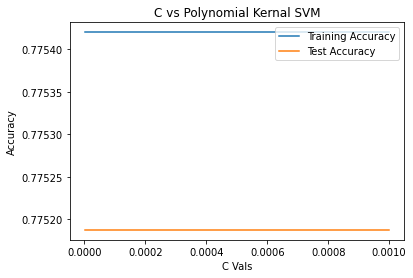

In [123]:
#linear = test_svm("linear", X_train, Y_train, X_test, Y_test)
#rbf = test_svm("rbf", X_train, Y_train, X_test, Y_test)
poly = test_svm("poly", X_train, Y_train, X_test, Y_test, cVals = polyCVals)
#plot_acc_vs_cval(cVals, linear, "C vs Linear Kernal SVM")
#plot_acc_vs_cval(cVals, rbf, "C vs RBF Kernal SVM")
plot_acc_vs_cval(polyCVals, poly, "C vs Polynomial Kernal SVM")

## One-hot encoding the team names

An attempt is made to increase the test accuracy by one-hot encoding the team names. The motivation for doing so lies in the fact that different teams likely perform differently and independent of other teams. Therefore, encoding the team names as a linear value may be unecessarily...

In [244]:
# Convert the team names back into strings again
num_to_team = dict(zip(range(len(set_of_teams)), set_of_teams))
all_teams = [num_to_team[i] for i in range(len(set_of_teams))]

# Extract the team data from the original DataFrame
team_1_arr = np.array(X["team_1"])
team_2_arr = np.array(X["team_2"])

# Create the one-hot vectors for each row of the data, one for each team
one_hot_t1 = np.zeros((team_1_arr.size, len(num_to_team)))
one_hot_t1[np.arange(team_1_arr.size), team_1_arr] = 1

one_hot_t2 = np.zeros((team_2_arr.size, len(num_to_team)))
one_hot_t2[np.arange(team_2_arr.size), team_2_arr] = 1

# Combine the matrix of one-hot vectors for team_1 and team_2 together to create a single matrix
one_hot = np.hstack((one_hot_t1, one_hot_t2))

# Turn the numpy array into a pandas DataFrame and add it to the dataset
one_hot_df = pd.DataFrame(one_hot, columns = ["team_1_%s" %(i) for i in all_teams] + ["team_2_%s" %(i) for i in all_teams])
X = X.drop(columns = ["team_1", "team_2"])
X = X.join(one_hot_df)


Once again, the data has is split into training and validation sets

In [245]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

And run again through multiple SVMs with varying C values and kernel types

In [ ]:
linear = test_svm("linear", X_train, Y_train, X_test, Y_test)
rbf = test_svm("rbf", X_train, Y_train, X_test, Y_test)
poly = test_svm("poly", X_train, Y_train, X_test, Y_test, cVals = polyCVals)
plot_acc_vs_cval(cVals, linear, "C vs Linear Kernal SVM")
plot_acc_vs_cval(cVals, rbf, "C vs RBF Kernal SVM")
plot_acc_vs_cval(polyCVals, poly, "C vs Polynomial Kernal SVM")

Fitting SVM with linear kernel and c = 0.001000


In [ ]:
# Ideas to try
# ============
# - higher learning rate, higher c, with one hot encoding
# - polyfit with no one-hot
# - polyfit with one hot
# - psuedo one-hot encoding vs summing winner data
